# Diabetes prediction: random forest

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import configuration as config
import functions as funcs

## 1. Data preparation

### 1.1. Load data from disk

In [2]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset=pickle.load(input_file)

training_df=dataset['training']
testing_df=dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
10,4,110.0,92.0,30.539537,139.605830,37.6,0.191,30,0
529,0,111.0,65.0,20.261106,145.496846,24.6,0.660,31,0
131,9,122.0,56.0,31.994559,122.476862,33.3,1.114,33,1
187,1,128.0,98.0,41.000000,58.000000,32.0,1.321,33,1
409,1,172.0,68.0,49.000000,579.000000,42.4,0.702,28,1


## 2. Baseline model

In [4]:
model=RandomForestClassifier()
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy=accuracy_score(model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Accuracy of random forest model: {accuracy:.1f}%')

Accuracy of random forest model: 100.0%


In [5]:
cross_val_scores={
    'Model': [],
    'Score': []
}

scores=cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Baseline']*len(scores))
cross_val_scores['Score'].extend(scores)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 74.5 +/- 5.1%


## 3. Hyperparameter optimization

### 3.1. Hyperparameter grid search

In [6]:
%%time

hyperparameters={
    'n_estimators':[2,5,10,20],
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[2,5,10,15],
    'min_weight_fraction_leaf':[0.005,0.01,0.02],
    'max_features':[0.5,0.6,0.7,0.8],
    'min_impurity_decrease':[0.0005,0.001,0.002],
    'ccp_alpha':[0,10**-7,10**-6,10**-5]
}

search=GridSearchCV(
    RandomForestClassifier(),
    hyperparameters,
    return_train_score=True,
    scoring='accuracy',
    cv=7,
    n_jobs=-1
)

search_results=search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
model=search_results.best_estimator_
hyperparameters=search_results.best_params_

print('Best hyperparameters:\n')

for key, value in hyperparameters.items():
    print(f' {key}: {value}')

print()


Best hyperparameters:

 ccp_alpha: 1e-07
 criterion: log_loss
 max_depth: 10
 max_features: 0.7
 min_impurity_decrease: 0.002
 min_weight_fraction_leaf: 0.02
 n_estimators: 5

CPU times: user 48.5 s, sys: 1.19 s, total: 49.7 s
Wall time: 2min 4s


### 3.2. Hyperparameter optimization results

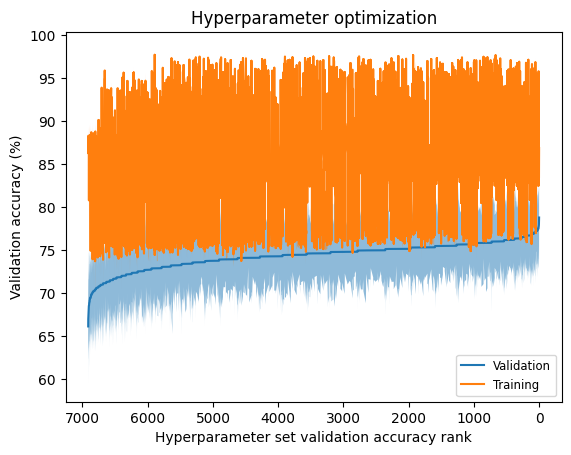

In [7]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

In [8]:
scores=cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized']*len(scores))
cross_val_scores['Score'].extend(scores)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 72.2 +/- 5.7%


## 4. Evaluation

### 4.1. Model comparison

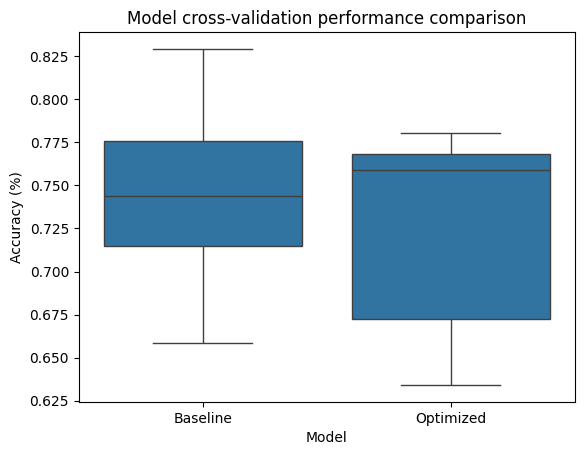

In [9]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

### 4.2. Test set performance

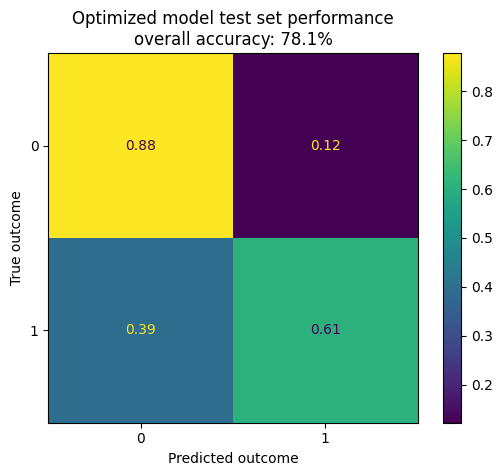

In [10]:
testing_predictions=model.predict(testing_df.drop('Outcome', axis=1))
accuracy=accuracy_score(testing_predictions, testing_df['Outcome'])*100

# Plot the confusion matrix
cm=confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Optimized model test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()

## 5. Save

### 5.1. Optimized hyperparameters

In [11]:
with open(config.RANDOM_FOREST_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 6.2. Model

In [12]:
with open(config.RANDOM_FOREST_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)